In [1]:
pip install folium contextily geopandas shapely

In [2]:
# Basic
import pandas as pd
import numpy as np

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn ML + Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Peta + GPS
import folium
from folium.plugins import HeatMap

# Filtering & Warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount ('/content/gdrive')
path = "/content/gdrive/MyDrive/Praktikum_ML/Latihan11"

Mounted at /content/gdrive


In [4]:
df = pd.read_csv(path +'/Data/2021socio_economic_indonesia.csv')
gps = pd.read_csv(path +'/Data/lat_long_kota_kab.csv')

In [5]:
data = df.merge(gps, left_on='cities_reg', right_on='name', how='inner')

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   province               514 non-null    object 
 1   cities_reg             514 non-null    object 
 2   poorpeople_percentage  514 non-null    float64
 3   reg_gdp                514 non-null    float64
 4   life_exp               514 non-null    float64
 5   avg_schooltime         514 non-null    float64
 6   exp_percap             514 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 28.2+ KB


,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap
count,514.000000,514.000000,514.000000,514.000000,514.000000
mean,12.273152,34.798333,69.619076,8.436615,10324.787938
std,7.458703,84.155498,3.455911,1.630842,2717.144186
min,2.380000,1.042000,55.370000,1.420000,3976.000000
25%,7.150000,5.587500,67.336250,7.510000,8574.000000
50%,10.455000,13.068500,69.922500,8.305000,10196.500000
75%,14.887500,28.849500,72.018750,9.337500,11719.000000
max,41.660000,819.000000,77.855000,12.830000,23888.000000


In [7]:
df['cities_reg'] = df['cities_reg'].str.upper().str.strip()
gps['name'] = gps['name'].str.upper().str.strip()

In [8]:
data = df.merge(gps, left_on='cities_reg', right_on='name', how='inner')

In [9]:
data.isna().sum()

,0
province,0
cities_reg,0
poorpeople_percentage,0
reg_gdp,0
life_exp,0
avg_schooltime,0
exp_percap,0
Unnamed: 0,0
id,0
foreign,0


In [10]:
data = data.drop_duplicates()

In [11]:
drop_cols = ['province', 'cities_reg', 'name']
clean = data.drop(columns=drop_cols)

In [12]:
clean.describe()

,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap,Unnamed: 0,id,foreign,lat,long
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,7.290816,69.616224,72.120153,10.651020,13572.979592,222.000000,3844.387755,37.714286,-3.030190,109.976379
std,3.762508,137.333425,2.474566,0.921388,2772.255310,134.975828,2351.487836,23.521870,4.079017,9.378492
min,2.380000,1.533000,63.425000,7.900000,7385.000000,18.000000,1171.000000,11.000000,-10.174140,95.320800
25%,4.775000,7.644000,70.936250,10.162500,11826.250000,111.250000,1671.250000,16.000000,-6.843027,102.949938
50%,6.410000,16.501000,72.285000,10.780000,13285.500000,216.500000,3371.500000,33.000000,-3.430610,107.920515
75%,8.822500,54.812000,73.803750,11.305000,14930.500000,326.750000,6171.750000,61.000000,0.526212,115.122980
max,23.260000,701.980000,77.610000,12.830000,23888.000000,513.000000,9471.000000,94.000000,5.892850,140.675400


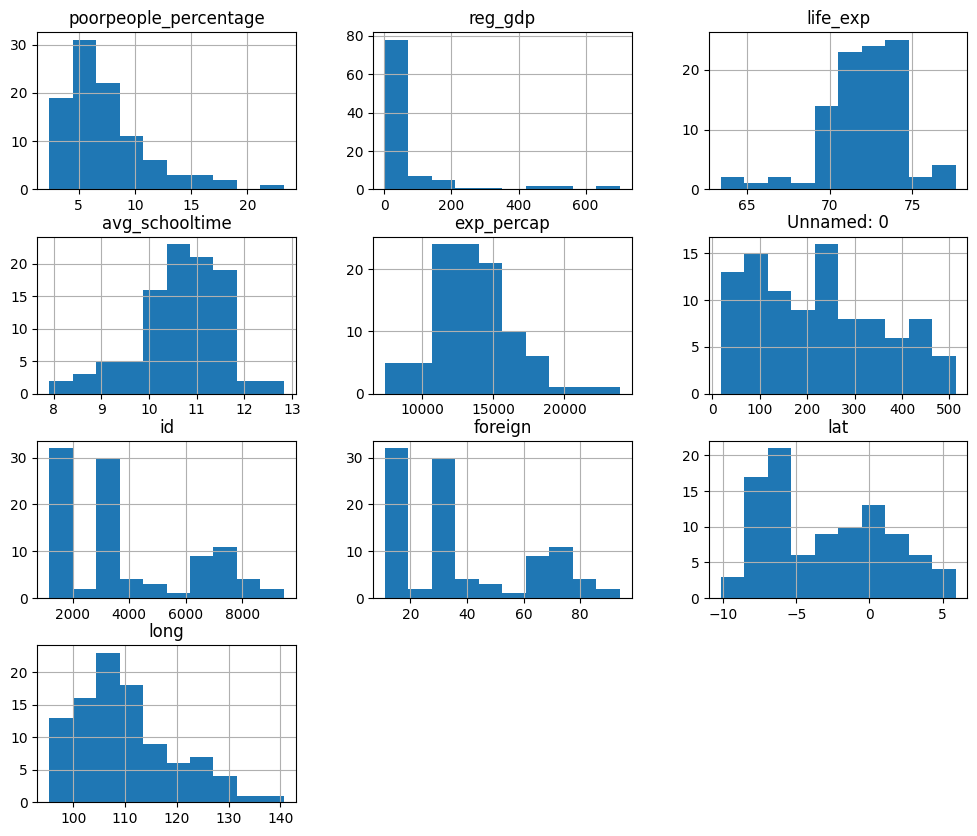

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

clean.hist(figsize=(12,10))
plt.show()

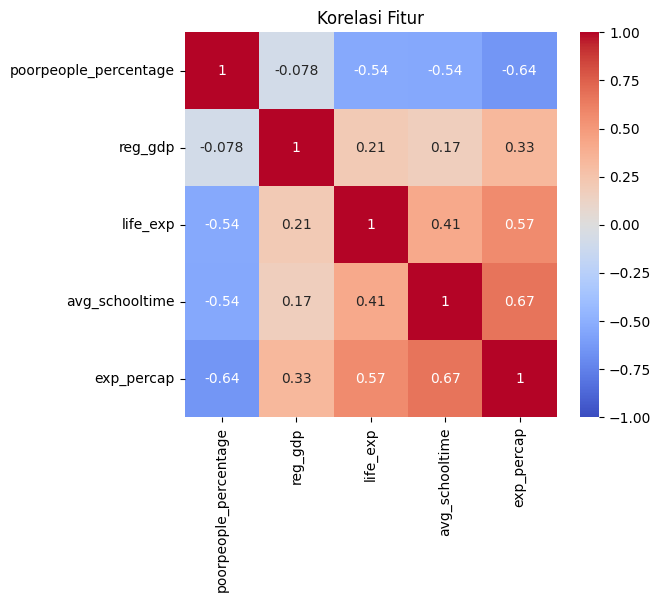

In [14]:
plt.figure(figsize=(6,5))
sns.heatmap(df.select_dtypes(include='number').corr(),
            annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1)
plt.title("Korelasi Fitur")
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(clean)

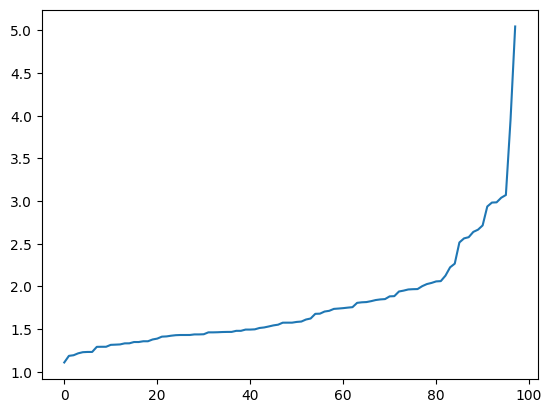

In [16]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

dist = np.sort(distances[:,4])
plt.plot(dist)


In [17]:
db = DBSCAN(eps=1.5, min_samples=5).fit(X_scaled)
data['cluster'] = db.labels_


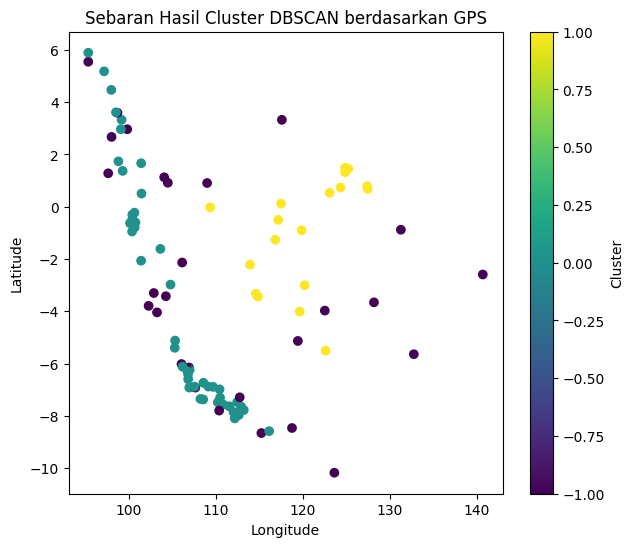

In [18]:
plt.figure(figsize=(7,6))
plt.scatter(
    data['long'],
    data['lat'],
    c=data['cluster'],
    cmap='viridis'
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Sebaran Hasil Cluster DBSCAN berdasarkan GPS")
plt.colorbar(label='Cluster')
plt.show()


In [19]:
import folium

m = folium.Map(location=[-3,115], zoom_start=5)

for i,row in data.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=4,
        popup=row['cities_reg'],
        color='blue' if row['cluster']!=-1 else 'red',
        fill=True,
    ).add_to(m)

m
